# Notes
- On removal of 'storing' from the corpus, it is seen that some rules with high support values are removed. Those are the rules that contain 'storing' with 'lbk' or 'urgent'.


# Utils

In [31]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud

In [33]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
def correct_types(df, column='SO_Omschrijving'):
    """
    Preprocess the specified column in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """

    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)
    return df

def replace_punctuation(text):
    """
    Replace punctuation in the input text.

    Parameters:
    - text (str): The input text in which punctuation will be replaced.

    Returns:
    - str: The input text with punctuation replaced.
    """
    # Replace "'s" with empty space.
    text = text.replace("'s", '')

    # Create a translation table to replace '.' and "'" with empty space, and other punctuation with spaces.
    translator = str.maketrans({'.': '', "'": '', **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}})

    cleaned_text = text.translate(translator)

    return cleaned_text

def remove_numerical_values(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    # Remove standalone numbers with optional floating points; such as 154, 99.31.
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)

    # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
    text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)

    # Remove numerical quantifiers; such as 1x OH.
    text = re.sub(r'\b\d+[xX]\b', '', text)

    return text

def stemize(text):
    """
    Perform stemming on the input text using the Dutch Snowball Stemmer.

    Parameters:
    - text (str): The input text to be stemmed.

    Returns:
    str: The stemmed text.

    Example:
    >>> stemize("This is an example text for stemming.")
    'thi is an exampl text for stem.'
    """
    stemmer = SnowballStemmer("dutch")
    tokens = word_tokenize(text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def normalize_lookups():
    """
    Normalize and preprocess the global lookup lists.

    This function performs the following operations on each global lookup list:
    1. Orders lookup lists by length in descending order.
    2. Initializes the Dutch Snowball Stemmer.
    3. Replaces punctuations using the `replace_punctuation` function.
    4. Removes numerical values using the `remove_numerical_values` function.
    5. Applies stemming using the `stemize` function.
    6. Converts the resulting list to a set.

    Note: The original lookup lists are modified in-place.

    Returns:
    None
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]

    # Initialize stemmer.
    # stemmer = SnowballStemmer("dutch")

    for lookup_list_name in lookup_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values(replace_punctuation(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

def group_items(description):
    """
    Group items in a description based on predefined lookup lists.

    Parameters:
    - description (str): The input description to be categorized.

    Returns:
    str: The category type of the description based on predefined lookup lists.
         If no match is found, 'Unknown' is returned.

    Example:
    >>> group_items("This is a description containing ventilation keywords.")
    'Ventilation'
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]

    # Order lookup lists by length in descending order.
    lookup_lists = sorted(lookup_lists, key=lambda x: len(globals()[x]), reverse=True)

    for lookup_list_name in lookup_lists:
        lookup_list = globals()[lookup_list_name]

        for word in lookup_list:
            if word in description:
                type_name = module_names[lookup_list_name.split('_')[1]]
                return type_name
    return 'Unknown'

def rules_to_coordinates(rules):
    """
    Convert association rules to coordinates.

    Parameters:
    - rules (pd.DataFrame): DataFrame containing association rules with 'antecedents', 'consequents', and other columns.

    Returns:
    - pd.DataFrame: DataFrame with 'antecedent', 'consequent', and 'rule' columns representing coordinates.
    """

    # Extract the first item from antecedents and consequents.
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])

    # Assign rule index to a new column 'rule'.
    rules['rule'] = rules.index

    # Select relevant columns for coordinates.
    coords = rules[['antecedent', 'consequent', 'rule']]

    return coords

def contains_word_regex(sentence, target_word):
    """
    Check if a given word is present in a sentence using regex.

    Parameters:
    - sentence (str): The input sentence to check.
    - target_word (str): The word to look for in the sentence.

    Returns:
    - bool: True if the word is found, False otherwise.
    """
    # Construct a regex pattern to match the whole word, case-insensitive.
    pattern = r'\b' + re.escape(target_word) + r'\b'
    
    # Use re.search to find the pattern in the sentence.
    match = re.search(pattern, sentence, flags=re.IGNORECASE)
    
    # Return True if a match is found, False otherwise.
    return bool(match)

In [35]:
lookup_ventilation = [
    "lbk",
    "luchtbehandeling",
    "luchtbehandelen",
    "luchbehandeling",
    "luchtbehandeling",
    "ventilatiesysteem",
    "ventilatie",
    "luchtklep",
    "stoombevochtiger",
    "stoombevochtiging",
    "bevochtiger",
    "toevoerventilator",
    "afvoerventilator",
    "ventilatormotor",
    "dakventilatoren",
    "Dakventilator",
    "Afzuiventilator",
    "wiel",
    "afzuigvent",
    "Vsnaren",
    "V snaren",
    "filters",
    "snaarbreuk",
    "condensafvoer",
    "condensor",
    "filter",
    "Luchtbeh",
    "LBH",
    "vorst",
    "verwarmingsbatterij",
    "stoomvochtiger",
    "luchtdebiet",
    "luchtzakken",
    "fancoil",
    "splitunit",
    "fancoil",
    "splitunit",
    "fancoil",
    "split-unit"
]

module_names = {
    "complaints": "Complaints",
    "regularMaintenance": "Regular Maintenance",
    "faultRedemption": "Fault Redemption",
    "domesticWater": "Domestic Water",
    "office": "Office",
    "waterDistribution": "Water Distribution",
    "bms": "BMS",
    "wkk": "WKK",
    "elevator": "Elevator",
    "lighting": "Lighting",
    "heatPump": "Heat Pump",
    "sanitary": "Sanitary",
    "fireSafety": "Fire Safety",
    "shading": "Shading",
    "entrance": "Entrance",
    "ventilation": "Ventilation",
    "heating": "Heating",
    "cooling": "Cooling"
}

# Data Reading

In [36]:
path = './Navision Serviceorder data.xlsx'

# Read the Excel file into a DataFrame.
df_so = pd.read_excel(path)
df_so.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_so = df_so[columns_to_select]

# This dataframe is used for testing purposes.
df_original = df_so.copy()
df_original.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_original = df_original[columns_to_select]


# Data Cleaning

In [37]:
# Create a copy from the original dataset.
df_so_cleaned = correct_types(df_so, column='SO_Omschrijving')

# Replace punctuations.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(replace_punctuation)

# Remove numerical values.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(remove_numerical_values)

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
stop_words.add('via')
stop_words.add('storing')
# stop_words.discard('niet')
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemize the text.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(stemize)

df_so_cleaned.head()

,SO_Omschrijving,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
0,stoombevochtiger ruimt,44608,44609.0,154.18
1,wasbak pantry ruimt loopt slecht,44624,44624.0,229.58
2,bevochtiger lbk link,44627,44628.0,188.14
3,afzuig schakelar werkt keuk,44704,44704.0,250.17
4,snaarbreuk afzuigvent lbk recht,44742,44746.0,447.16


# Modules Grouping

In [38]:
df_so_cleaned['target'] = df_so_cleaned['SO_Omschrijving'].apply(group_items)
categorized_count = 0
for _, value in module_names.items():
    categorized_count = categorized_count + len(df_so_cleaned["target"][df_so_cleaned["target"] == value])
    print(f'{value} count: {len(df_so_cleaned["target"][df_so_cleaned["target"] == value])}')

Complaints count: 0
Regular Maintenance count: 0
Fault Redemption count: 0
Domestic Water count: 0
Office count: 0
Water Distribution count: 0
BMS count: 0
WKK count: 0
Elevator count: 0
Lighting count: 0
Heat Pump count: 0
Sanitary count: 0
Fire Safety count: 0
Shading count: 0
Entrance count: 0
Ventilation count: 533
Heating count: 0
Cooling count: 0


In [39]:
df_so_ventilation = df_so_cleaned[df_so_cleaned["target"].isin(["Ventilation"])]
df_so_ventilation.head()

,SO_Omschrijving,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target
0,stoombevochtiger ruimt,44608,44609.0,154.18,Ventilation
2,bevochtiger lbk link,44627,44628.0,188.14,Ventilation
4,snaarbreuk afzuigvent lbk recht,44742,44746.0,447.16,Ventilation
9,lbk recht stoomomvormer 100sb01,44972,44973.0,133.81,Ventilation
16,stoomomvormer lbk recht,45044,45047.0,366.47,Ventilation


# Preparation

In [40]:
# Split transaction strings into lists.
transactions = df_so_ventilation['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert DataFrame column into list of strings.
transactions_ventilation = list(transactions)

print(transactions_ventilation)

[['stoombevochtiger', 'ruimt'], ['bevochtiger', 'lbk', 'link'], ['snaarbreuk', 'afzuigvent', 'lbk', 'recht'], ['lbk', 'recht', 'stoomomvormer', '100sb01'], ['stoomomvormer', 'lbk', 'recht'], ['rk', 'lbk', 'link', 'afzuigventilator', '100av01'], ['mer', 'ruimt', 'rk', 'lbk', 'link', 'communicatie', 'alarm'], ['snaarbreuk', 'afzuigvent', 'rk', 'lbk', 'recht'], ['snaarbreuk', 'afzuigvent', '100pdt02'], ['snaarbreuk', 'afzuigvent'], ['lbk', 'recht', 'snaarbreuk'], ['stoomomvormer', 'rk3', 'lbk', 'link'], ['lbk'], ['fancoil', 'unit', 'mak', 'lawaai'], ['ventilatiesystem', 'stat'], ['afzuigventilator', 'produktie', 'start'], ['frequentieregelar', 'ventilatie', 'keuk'], ['luchtbehandelingsystem', 'valt', 'sted'], ['pomp', 'fancoil'], ['pomp', 'fancoil'], ['ruimt', 'lbk', 'melding'], ['stoomvormer', 'lbk'], ['ruimtetemp', 'ruimt', 'lbk', 'max', 'gr'], ['lbk', 'schakel'], ['spoed', 'luchtbehandelingsystem'], ['koelmachin', 'luchtbehandelingskast', 'uitgevall'], ['koelmachin', 'luchtbehandelings

In [41]:
# Instantiate transaction encoder and identify unique items in transactions.
encoder = TransactionEncoder().fit(transactions_ventilation)

# One-hot encode transactions.
onehot_ventilation = encoder.transform(transactions_ventilation)
onehot_ventilation = pd.DataFrame(onehot_ventilation, columns=encoder.columns_)

# Algorithm

**Itemsets Creation**

In [42]:
# Compute frequent itemsets using the Apriori algorithm.
n = 1
frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                            min_support =  n/len(onehot_ventilation),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')

frequent_itemsets_ventilation = frequent_itemsets_ventilation.sort_values(by=['support'], ascending=False).reset_index(drop=True)
length_1 = len(frequent_itemsets_ventilation[frequent_itemsets_ventilation['itemsets'].apply(lambda x: len(x)) == 1])
length_2 = len(frequent_itemsets_ventilation[frequent_itemsets_ventilation['itemsets'].apply(lambda x: len(x)) == 2])
length_3 = len(frequent_itemsets_ventilation[frequent_itemsets_ventilation['itemsets'].apply(lambda x: len(x)) == 3])
length_more_than_3 = len(frequent_itemsets_ventilation[frequent_itemsets_ventilation['itemsets'].apply(lambda x: len(x)) > 3])
print(f'Number of frequent itemsets with length 1: {length_1}')
print(f'Number of frequent itemsets with length 2: {length_2}')
print(f'Number of frequent itemsets with length 3: {length_3}')
print(f'Number of frequent itemsets with length more than 3: {length_more_than_3}')
frequent_itemsets_ventilation.head()

Processing 348690 combinations | Sampling itemset size 2

Processing 480 combinations | Sampling itemset size 8 764
Number of transactions: 533
Number of frequent itemsets: 7447
Number of frequent itemsets with length 1: 591
Number of frequent itemsets with length 2: 2254
Number of frequent itemsets with length 3: 2502
Number of frequent itemsets with length more than 3: 2100


,support,itemsets
0,0.367730,(lbk)
1,0.183865,(ventilatie)
2,0.076923,(mp)
3,0.073171,(ventilatiesystem)
4,0.065666,(filter)


**Rules Creation**

In [43]:
# Compute all association rules for frequent_itemsets.
rules_ventilation = association_rules(frequent_itemsets_ventilation, 
                            metric = "lift", 
                         	min_threshold = 1)

rules_ventilation = rules_ventilation.sort_values(by=['support'], ascending=False).reset_index(drop=True)
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')
print(f'Number of rules: {len(rules_ventilation)}')
rules_ventilation.head(50)

Number of frequent itemsets: 7447
Number of rules: 62754


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ventilatie),(werkt),0.183865,0.050657,0.026266,0.142857,2.820106,0.016952,1.107567,0.790805
1,(snaarbreuk),(lbk),0.041276,0.367730,0.026266,0.636364,1.730519,0.011088,1.738743,0.440313
2,(lbk),(snaarbreuk),0.367730,0.041276,0.026266,0.071429,1.730519,0.011088,1.032472,0.667656
3,(werkt),(ventilatie),0.050657,0.183865,0.026266,0.518519,2.820106,0.016952,1.695050,0.679842
4,(urgent),(lbk),0.030019,0.367730,0.022514,0.750000,2.039541,0.011475,2.529081,0.525467
5,(lbk),(urgent),0.367730,0.030019,0.022514,0.061224,2.039541,0.011475,1.033241,0.806133
6,(maakt),(lawaai),0.037523,0.028143,0.020638,0.550000,19.543333,0.019582,2.159683,0.985823
7,(lawaai),(maakt),0.028143,0.037523,0.020638,0.733333,19.543333,0.019582,3.609287,0.976307
8,(lucht),(blaast),0.028143,0.030019,0.018762,0.666667,22.208333,0.017917,2.909944,0.982625
9,(blaast),(lucht),0.030019,0.028143,0.018762,0.625000,22.208333,0.017917,2.591620,0.984526


**Test Section**

In [44]:
rule_index = 3
word_list = list(rules_ventilation.iloc[rule_index]['antecedents'])
word_list.extend(list(rules_ventilation.iloc[rule_index]['consequents']))
indices = []
for transaction in df_so['SO_Omschrijving']:
    if all(contains_word_regex(transaction, word) for word in word_list):
        indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
    print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}")

Original Dataset: 14 items
7312              (EV) Ventilatie in douche werkt niet goed
8084     (MP) verwarming werkt niet, mechanische ventilatie
8400                   (MP) ventilatie/afzuiging werkt niet
9171                            (JB) Ventilatie werkt niet.
9640                          Ventilatie app 15 werkt niet 
9662     Ventilatie werkt niet slaapkamer/badkamer app. 15 
9790                     Studio 4 werkt de ventilatie niet.
9858     Ventilatie in woning werkt niet goed, blaast vieze
10434    Mech. ventilatie badkamer bovenverdieping werkt ni
10960                    Ventilatie werkt niet in toiletten
11509    Ventilatie uitslaapkamer/tandartskamer werkt niet*
11659     Het ventilatie systeem werkt  niet in de lokalen*
13462     Mechanische ventilatie, werkt niet /vreemd geluid
15535             Ventilatie 1e verdieping werkt niet goed.
Name: SO_Omschrijving, dtype: object

Cleaned Dataset: 14 items
7312                     ev ventilatie douch werkt goed
8084         

# Analysis

In [45]:
df_original = pd.read_excel(path)
df_original.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_original = df_original[columns_to_select]

In [46]:
flag = rules_ventilation[rules_ventilation['lift'] < 1].copy()
print(len(flag))

0


In [47]:
rules_one_consequent = rules_ventilation[rules_ventilation['antecedents'].apply(len) == 2]
print(len(rules_one_consequent))
rules_one_consequent.head(60)

23191


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
37,"(lucht, blaast)",(koud),0.018762,0.018762,0.011257,0.600000,31.980000,0.010905,2.453096,0.987253
38,"(koud, lucht)",(blaast),0.013133,0.030019,0.011257,0.857143,28.553571,0.010863,6.789869,0.977820
39,"(koud, blaast)",(lucht),0.011257,0.028143,0.011257,1.000000,35.533333,0.010940,inf,0.982922
68,"(ventilatie, maakt)",(lawaai),0.015009,0.028143,0.009381,0.625000,22.208333,0.008958,2.591620,0.969524
69,"(ventilatie, lawaai)",(maakt),0.011257,0.037523,0.009381,0.833333,22.208333,0.008958,5.774859,0.965844
70,"(maakt, lawaai)",(ventilatie),0.020638,0.183865,0.009381,0.454545,2.472171,0.005586,1.496248,0.608046
98,"(wtw, unit)",(filter),0.009381,0.065666,0.007505,0.800000,12.182857,0.006889,4.671670,0.926610
99,"(wtw, filter)",(unit),0.007505,0.030019,0.007505,1.000000,33.312500,0.007279,inf,0.977316
100,"(unit, filter)",(wtw),0.009381,0.011257,0.007505,0.800000,71.066667,0.007399,4.943715,0.995265
104,"(bevocht, gebouw)","(c, lbk)",0.007505,0.007505,0.007505,1.000000,133.250000,0.007448,inf,1.000000


In [48]:
word_list = list(rules_ventilation.iloc[0]['antecedents'])
indices = []
for transaction in df_so['SO_Omschrijving']:
    if all(contains_word_regex(transaction, word) for word in word_list):
        indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
    print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}")

Original Dataset: 98 items
75             Storing frequentieregelaar ventilatie keuken
1434                                (HZ) storing ventilatie
1461                                 (RA) Ventilatie defect
1504                   (IV) Ventilatie storing inbr install
1504                   (IV) Ventilatie storing inbr install
1535            (JB) Kappen klapperen op dak van ventilatie
1681            (MP)plafond ventilatie maakt tikkend geluid
2349                      Storing Algemeen ventilatie 46A-3
2419                      (JB) Ventilatie maakt veel lawaai
2590                 TESTBON: Ventilatie maakt veel lawaai.
2739                                    Ventilatie storing.
2902                             Urgente storing ventilatie
2949              LBK nieuwbouw in storing geen ventilatie 
3133         Ventilatie blaast koude lucht in. Ruimte RL116
3261                       Nazien koelmachine en ventilatie
4911             Lekkage CV/ Ventilatie Leiding in magazijn
6132     Vent

# Visualization

**Heatmap**

Processing 60 combinations | Sampling itemset size 3 2
Number of transactions: 533
Minimum number of occurrence for each itemset: 10
Minimum support threshold for itemsets: 0.01876172607879925
number of frequent itemsets: 40
Number of rules: 10


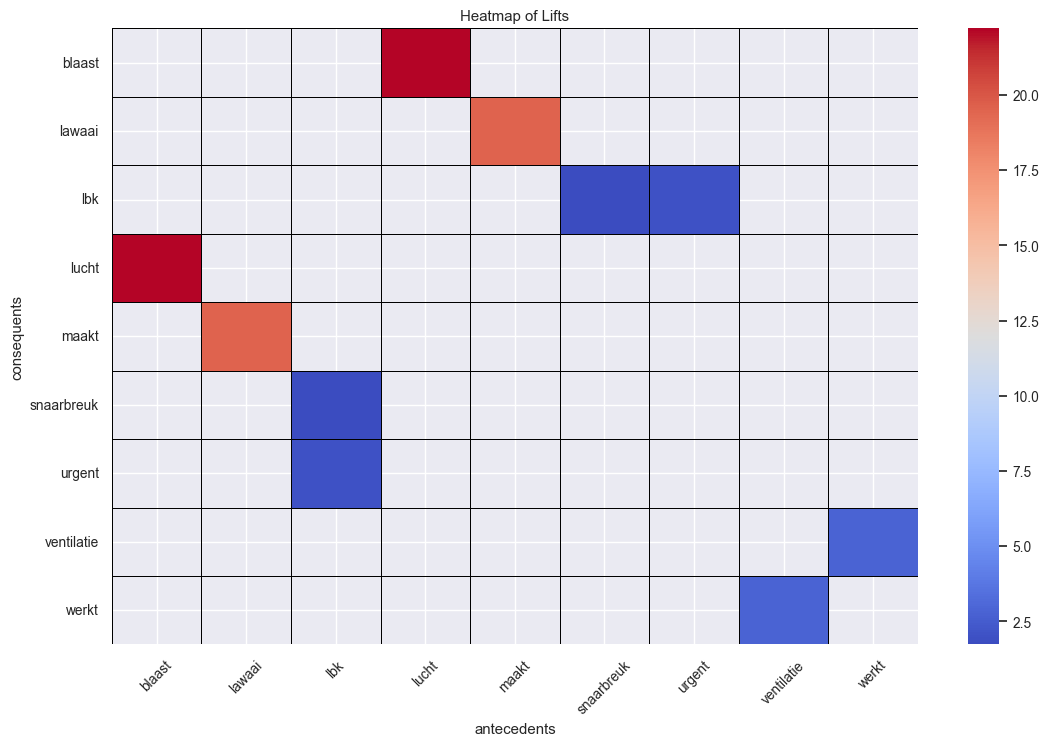

In [49]:
n = 10
minimum_support = n/len(onehot_ventilation)
frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                            min_support =  minimum_support,
                            use_colnames = True,
                            verbose = 1)

rules_ventilation = association_rules(frequent_itemsets_ventilation, metric = 'lift', min_threshold = 1)

print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'number of frequent itemsets: {len(frequent_itemsets_ventilation)}')
print(f'Number of rules: {len(rules_ventilation)}')

# Replace frozen sets with strings.
rules_ventilation['antecedents'] = rules_ventilation['antecedents'].apply(lambda a: ','.join(list(a)))
rules_ventilation['consequents'] = rules_ventilation['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_ventilation.pivot(index='consequents', columns='antecedents', values='lift')
sns.set(font_scale=0.9)  # Adjust the font size as needed
plt.figure(figsize=(13, 8))  # Adjust width and height as needed
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')
plt.xticks(rotation=45)
plt.title('Heatmap of Lifts')
plt.yticks(rotation=0)
plt.show()

**Antecedent-Consequent Support Scatterplot**

Processing 480 combinations | Sampling itemset size 8 764
Number of transactions: 533
Number of frequent itemsets: 7447
Minimum support: 0.001876172607879925
Number of rules: 62754


<Axes: xlabel='antecedent support', ylabel='consequent support'>

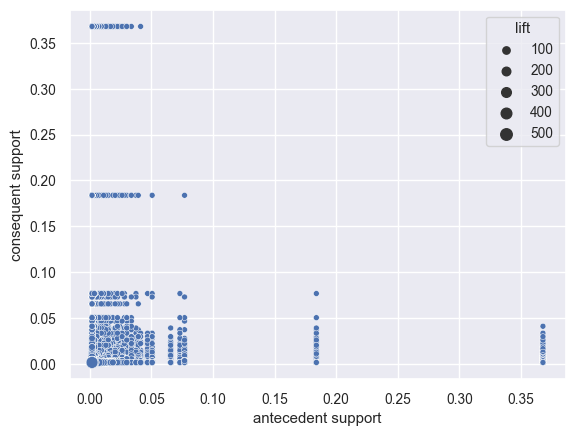

In [50]:
# Compute frequent itemsets using the Apriori algorithm.
frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                            min_support =  0.00000001, # Happenning at least 10 times.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')

rules_ventilation = association_rules(frequent_itemsets_ventilation, metric = 'lift', min_threshold = 1)
print(f"Minimum support: {rules_ventilation['support'].min()}")

print(f'Number of rules: {len(rules_ventilation)}')

sns.scatterplot(x='antecedent support', y='consequent support', size='lift', data=rules_ventilation)

**Support-Confidence Scatterplot**

Processing 60 combinations | Sampling itemset size 3 2
Number of transactions: 533
Number of frequent itemsets: 40
Number of rules: 10


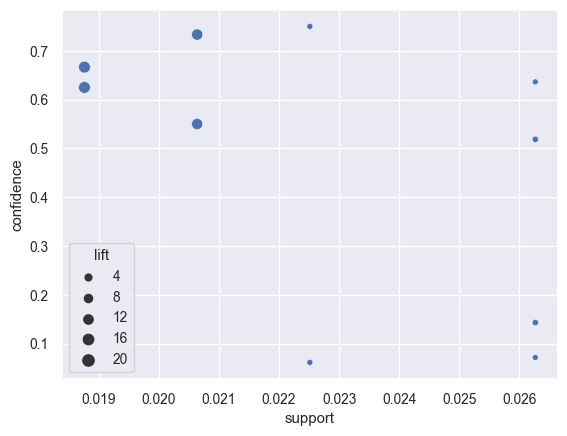

In [51]:
# Compute frequent itemsets using the Apriori algorithm.
frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                            min_support =  10/len(onehot_ventilation),
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')

rules_ventilation = association_rules(frequent_itemsets_ventilation, metric = 'lift', 
                          min_threshold = 1)

print(f'Number of rules: {len(rules_ventilation)}')

sns.scatterplot(x = "support", y = "confidence", size='lift', data = rules_ventilation)
rules_ventilation = rules_ventilation.sort_values(by=['support'], ascending=False).reset_index(drop=True)
plt.show()

In [52]:
rules_ventilation

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(snaarbreuk),(lbk),0.041276,0.367730,0.026266,0.636364,1.730519,0.011088,1.738743,0.440313
1,(lbk),(snaarbreuk),0.367730,0.041276,0.026266,0.071429,1.730519,0.011088,1.032472,0.667656
2,(ventilatie),(werkt),0.183865,0.050657,0.026266,0.142857,2.820106,0.016952,1.107567,0.790805
3,(werkt),(ventilatie),0.050657,0.183865,0.026266,0.518519,2.820106,0.016952,1.695050,0.679842
4,(urgent),(lbk),0.030019,0.367730,0.022514,0.750000,2.039541,0.011475,2.529081,0.525467
5,(lbk),(urgent),0.367730,0.030019,0.022514,0.061224,2.039541,0.011475,1.033241,0.806133
6,(maakt),(lawaai),0.037523,0.028143,0.020638,0.550000,19.543333,0.019582,2.159683,0.985823
7,(lawaai),(maakt),0.028143,0.037523,0.020638,0.733333,19.543333,0.019582,3.609287,0.976307
8,(lucht),(blaast),0.028143,0.030019,0.018762,0.666667,22.208333,0.017917,2.909944,0.982625
9,(blaast),(lucht),0.030019,0.028143,0.018762,0.625000,22.208333,0.017917,2.591620,0.984526


**Support-Lift Scatterplot**

Processing 60 combinations | Sampling itemset size 3 2
Number of transactions: 533
Number of frequent itemsets: 40
Number of rules: 10


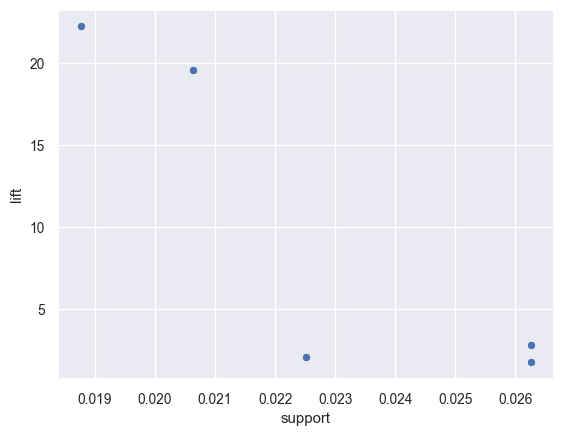

In [53]:
n = 10

frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                            min_support =  n/len(onehot_ventilation),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')

rules_ventilation = association_rules(frequent_itemsets_ventilation, metric = 'lift', 
                          min_threshold = 1)

print(f'Number of rules: {len(rules_ventilation)}')

sns.scatterplot(x = "support", y = "lift", data = rules_ventilation)
plt.show()

**Parallel-Coordinates Plot**

Processing 60 combinations | Sampling itemset size 3 2
Number of transactions: 533
Number of frequent itemsets: 40


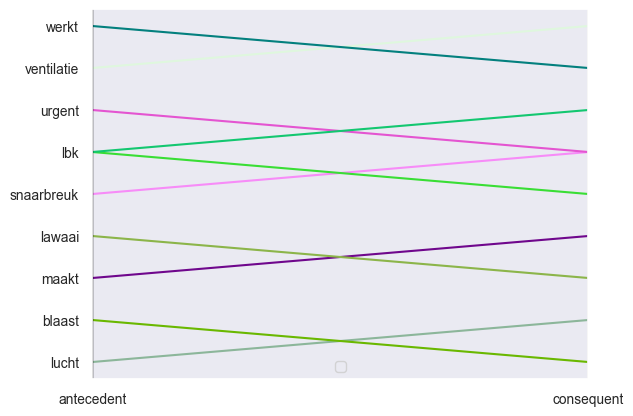

In [54]:
n = 10

frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                            min_support =  n/len(onehot_ventilation),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')

rules_ventilation = association_rules(frequent_itemsets_ventilation, metric = 'lift', 
                          min_threshold = 1)

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules_ventilation)

# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.show()

# Final Result

In [55]:
n = 11

# Finding frequent itemsets.
min_support = n / len(onehot_ventilation)
frequent_itemsets_ventilation = apriori(onehot_ventilation, 
                                        min_support=min_support,
                                        use_colnames=True,
                                        verbose=1)

# Generating association rules.
rules_ventilation = association_rules(frequent_itemsets_ventilation, 
                                       metric='lift', 
                                       min_threshold=1)

# Displaying information.
num_transactions = len(onehot_ventilation)
print(f'Number of transactions: {num_transactions}')
print(f'Minimum itemset support: {min_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')

# Sorting rules by support.
rules_ventilation = rules_ventilation.sort_values(by='support', ascending=False).reset_index(drop=True)

# Removing duplicate rules.
duplicates = set()
for i, row in rules_ventilation.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    for j, r in rules_ventilation.iloc[i+1:].iterrows():
        if consequent.union(antecedent) == r['antecedents'].union(r['consequents']):
            duplicates.add(j)

rules_ventilation.drop(index=duplicates, inplace=True)
rules_ventilation.reset_index(drop=True, inplace=True)

print(f'Number of rules: {len(rules_ventilation)}')
rules_ventilation

Processing 42 combinations | Sampling itemset size 32
Number of transactions: 533
Minimum itemset support: 0.020637898686679174
Number of frequent itemsets: 34
Number of rules: 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(snaarbreuk),(lbk),0.041276,0.367730,0.026266,0.636364,1.730519,0.011088,1.738743,0.440313
1,(ventilatie),(werkt),0.183865,0.050657,0.026266,0.142857,2.820106,0.016952,1.107567,0.790805
2,(urgent),(lbk),0.030019,0.367730,0.022514,0.750000,2.039541,0.011475,2.529081,0.525467
3,(maakt),(lawaai),0.037523,0.028143,0.020638,0.550000,19.543333,0.019582,2.159683,0.985823


In [56]:
rule_indices = list(range(0, len(rules_ventilation)))
rule_indices

# Set the maximum width of the columns.
pd.set_option('display.max_colwidth', None)

for row_index in rule_indices:
    word_list = list(rules_ventilation.iloc[row_index]['antecedents'])
    word_list.extend(list(rules_ventilation.iloc[row_index]['consequents']))
    indices = []
    for transaction in df_so['SO_Omschrijving']:
        if all(contains_word_regex(transaction, word) for word in word_list):
            indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
        print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}\n\n")

Original Dataset: 14 items
4                         Snaarbreuk afzuigvent. LBK rechts
24                 Snaarbreuk afzuigvent. RK_4: LBK Rechts.
33                                    lbk rechts snaarbreuk
186                            (RA) Snaarbreuk LBK BG t/m 6
968        Geen cv op afd. PUZA + snaarbreuk LBK centr. hal
3784                Vervolgactie M&R LBK kantoor snaarbreuk
4346                 Snaarbreuk afzuigvent LBK. ( RK3-OS4 )
4362                       Snaarbreuk afzuigvent. OS-4 LBK.
6100                                Storing LBK. Snaarbreuk
6724                               Snaarbreuk LBK Recreatie
6741                 storing lbk recreatieruimte snaarbreuk
12708                  LBK 5 restaurant en omgev snaarbreuk
13754                     Snaarbreuk toevoerventilator LBK 
13875    W Installatie urgent ,Snaarbreuk LBK van de zorg *
Name: SO_Omschrijving, dtype: object

Cleaned Dataset: 14 items
4                 snaarbreuk afzuigvent lbk recht
24             snaa